In [77]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import psycopg2 as pg
from sqlalchemy import create_engine

In [78]:
customer = pd.read_csv(r'.\data\customer.csv', sep=';')
transaction = pd.read_csv(r'.\data\transaction.csv', sep=';')

In [79]:
display(customer.head())
display(transaction.head())

,customer_id,first_name,last_name,gender,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,F,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,Eli,Bockman,Male,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,3,Arlin,Dearle,Male,1954-01-20,Recruiting Manager,Property,Mass Customer,N,Yes,0 Holy Cross Court,4211,QLD,Australia,9
3,4,Talbot,NaN,Male,1961-10-03,NaN,IT,Mass Customer,N,No,17979 Del Mar Point,2448,New South Wales,Australia,4
4,5,Sheila-kathryn,Calton,Female,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,9 Oakridge Court,3216,VIC,Australia,9


,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost
0,1,2,2950,25.02.2017,False,Approved,Solex,Standard,medium,medium,"71,49","53,62"
1,2,3,3120,21.05.2017,True,Approved,Trek Bicycles,Standard,medium,large,"2091,47","388,92"
2,3,37,402,16.10.2017,False,Approved,OHM Cycles,Standard,low,medium,"1793,43","248,82"
3,4,88,3135,31.08.2017,False,Approved,Norco Bicycles,Standard,medium,medium,"1198,46","381,10"
4,5,78,787,01.10.2017,True,Approved,Giant Bicycles,Standard,medium,large,"1765,3","709,48"


Для работы с SQL таблицами упростим данные и избавимся от всех пропусков.

In [80]:
customer = customer.dropna()
transaction = transaction.dropna()

In [81]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2780 entries, 0 to 3996
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   customer_id            2780 non-null   int64 
 1   first_name             2780 non-null   object
 2   last_name              2780 non-null   object
 3   gender                 2780 non-null   object
 4   DOB                    2780 non-null   object
 5   job_title              2780 non-null   object
 6   job_industry_category  2780 non-null   object
 7   wealth_segment         2780 non-null   object
 8   deceased_indicator     2780 non-null   object
 9   owns_car               2780 non-null   object
 10  address                2780 non-null   object
 11  postcode               2780 non-null   int64 
 12  state                  2780 non-null   object
 13  country                2780 non-null   object
 14  property_valuation     2780 non-null   int64 
dtypes: int64(3), object(12)
me

In [82]:
customer.dtypes

customer_id               int64
first_name               object
last_name                object
gender                   object
DOB                      object
job_title                object
job_industry_category    object
wealth_segment           object
deceased_indicator       object
owns_car                 object
address                  object
postcode                  int64
state                    object
country                  object
property_valuation        int64
dtype: object

In [83]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19445 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_id    19445 non-null  int64 
 1   product_id        19445 non-null  int64 
 2   customer_id       19445 non-null  int64 
 3   transaction_date  19445 non-null  object
 4   online_order      19445 non-null  object
 5   order_status      19445 non-null  object
 6   brand             19445 non-null  object
 7   product_line      19445 non-null  object
 8   product_class     19445 non-null  object
 9   product_size      19445 non-null  object
 10  list_price        19445 non-null  object
 11  standard_cost     19445 non-null  object
dtypes: int64(3), object(9)
memory usage: 1.9+ MB


In [84]:
transaction['list_price'] = pd.to_numeric(transaction['list_price'].apply(lambda x: x.replace(',', '.')))
transaction['standard_cost'] = pd.to_numeric(transaction['standard_cost'].apply(lambda x: x.replace(',', '.')))

In [85]:
transaction['transaction_date'] = pd.to_datetime(transaction['transaction_date'])
customer['DOB'] = pd.to_datetime(customer['DOB'])

In [86]:
transaction.dtypes

transaction_id               int64
product_id                   int64
customer_id                  int64
transaction_date    datetime64[ns]
online_order                object
order_status                object
brand                       object
product_line                object
product_class               object
product_size                object
list_price                 float64
standard_cost              float64
dtype: object

Создадим базу данных и загрузим туда таблицы

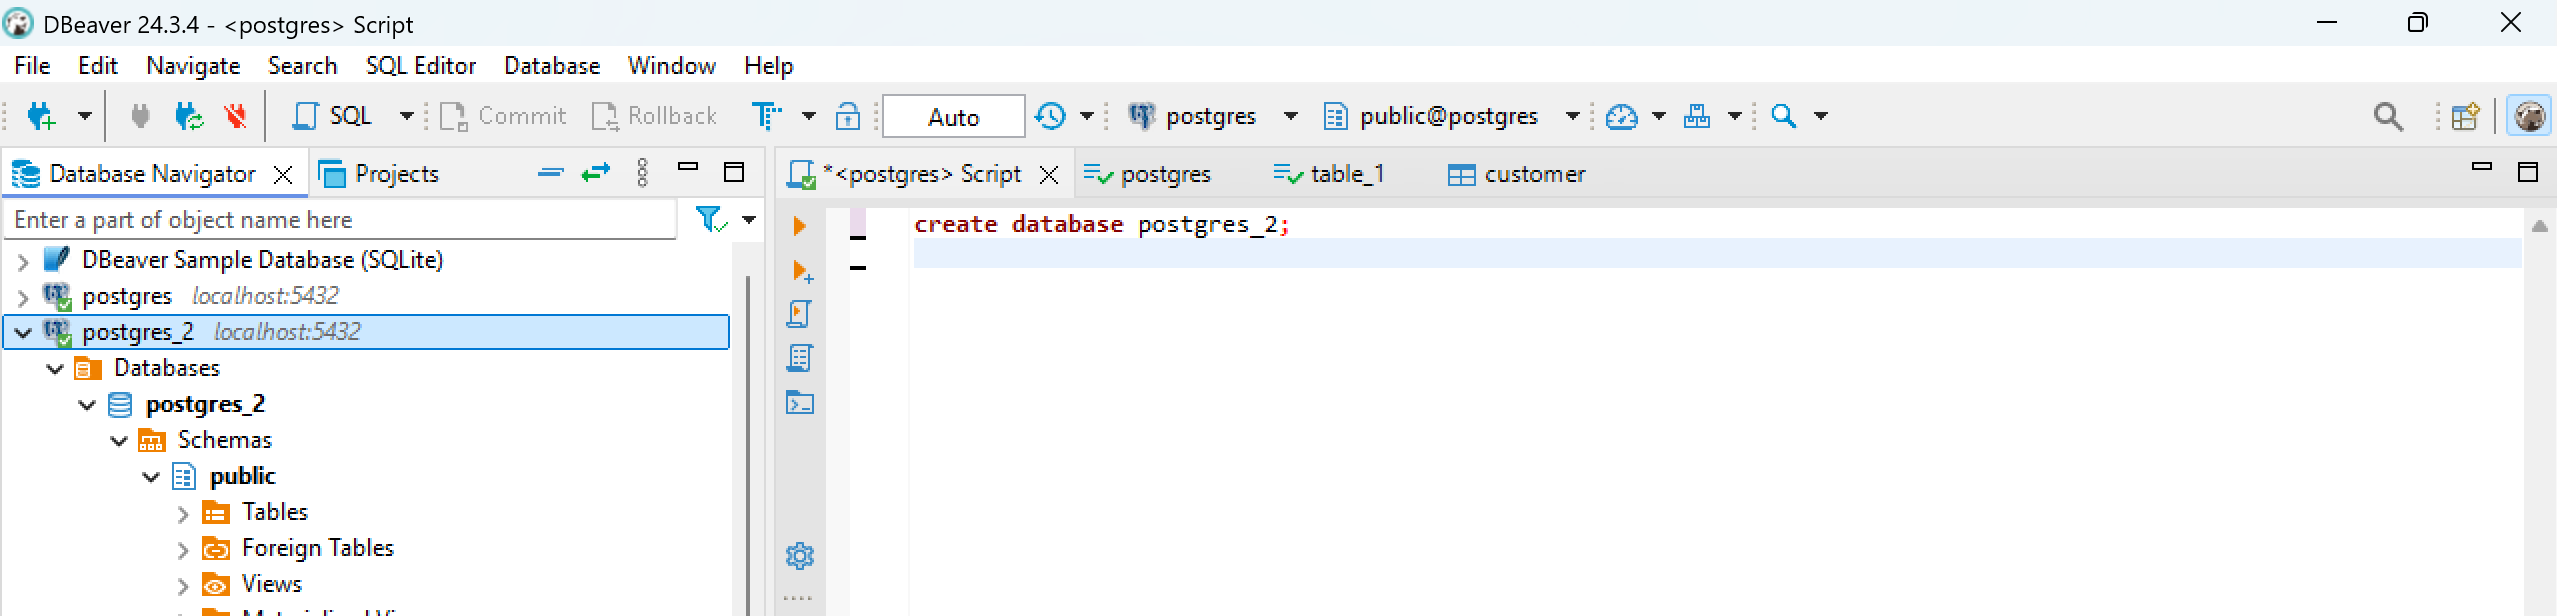

In [87]:
DB_NAME = "postgres_2"
USER = "postgres"
PASSWORD = "postgres"
HOST = "localhost"
PORT = "5432"

In [88]:
conn = pg.connect(dbname=DB_NAME , host=HOST, user=USER, password=PASSWORD, port=PORT)
cursor = conn.cursor()

In [89]:
conn.rollback()

In [90]:
cursor.execute(
    '''
    DROP TABLE IF EXISTS customer;
    '''
)

In [91]:
cursor.execute("""
    CREATE TABLE IF NOT EXISTS customer (
    customer_id INT PRIMARY KEY,
    first_name TEXT,         
    last_name TEXT,             
    gender TEXT,                 
    DOB DATE,                    
    job_title TEXT,               
    job_industry_category TEXT,   
    wealth_segment TEXT,          
    deceased_indicator TEXT,      
    owns_car TEXT,               
    address TEXT,              
    postcode INT,            
    state TEXT,          
    country TEXT,                
    property_valuation INT       
    );
""")

In [92]:
cursor.execute(
    '''
    DROP TABLE IF EXISTS transaction;
    '''
)

In [93]:
cursor.execute(
    '''
    CREATE TABLE IF NOT EXISTS transaction(
    transaction_id INT PRIMARY KEY,
    product_id INT,
    customer_id INT,
    transaction_date DATE,    
    online_order TEXT,        
    order_status TEXT,        
    brand TEXT,               
    product_line TEXT,       
    product_class TEXT,      
    product_size TEXT,        
    list_price FLOAT,          
    standard_cost FLOAT      
    )
    '''
)

In [94]:
conn.commit()

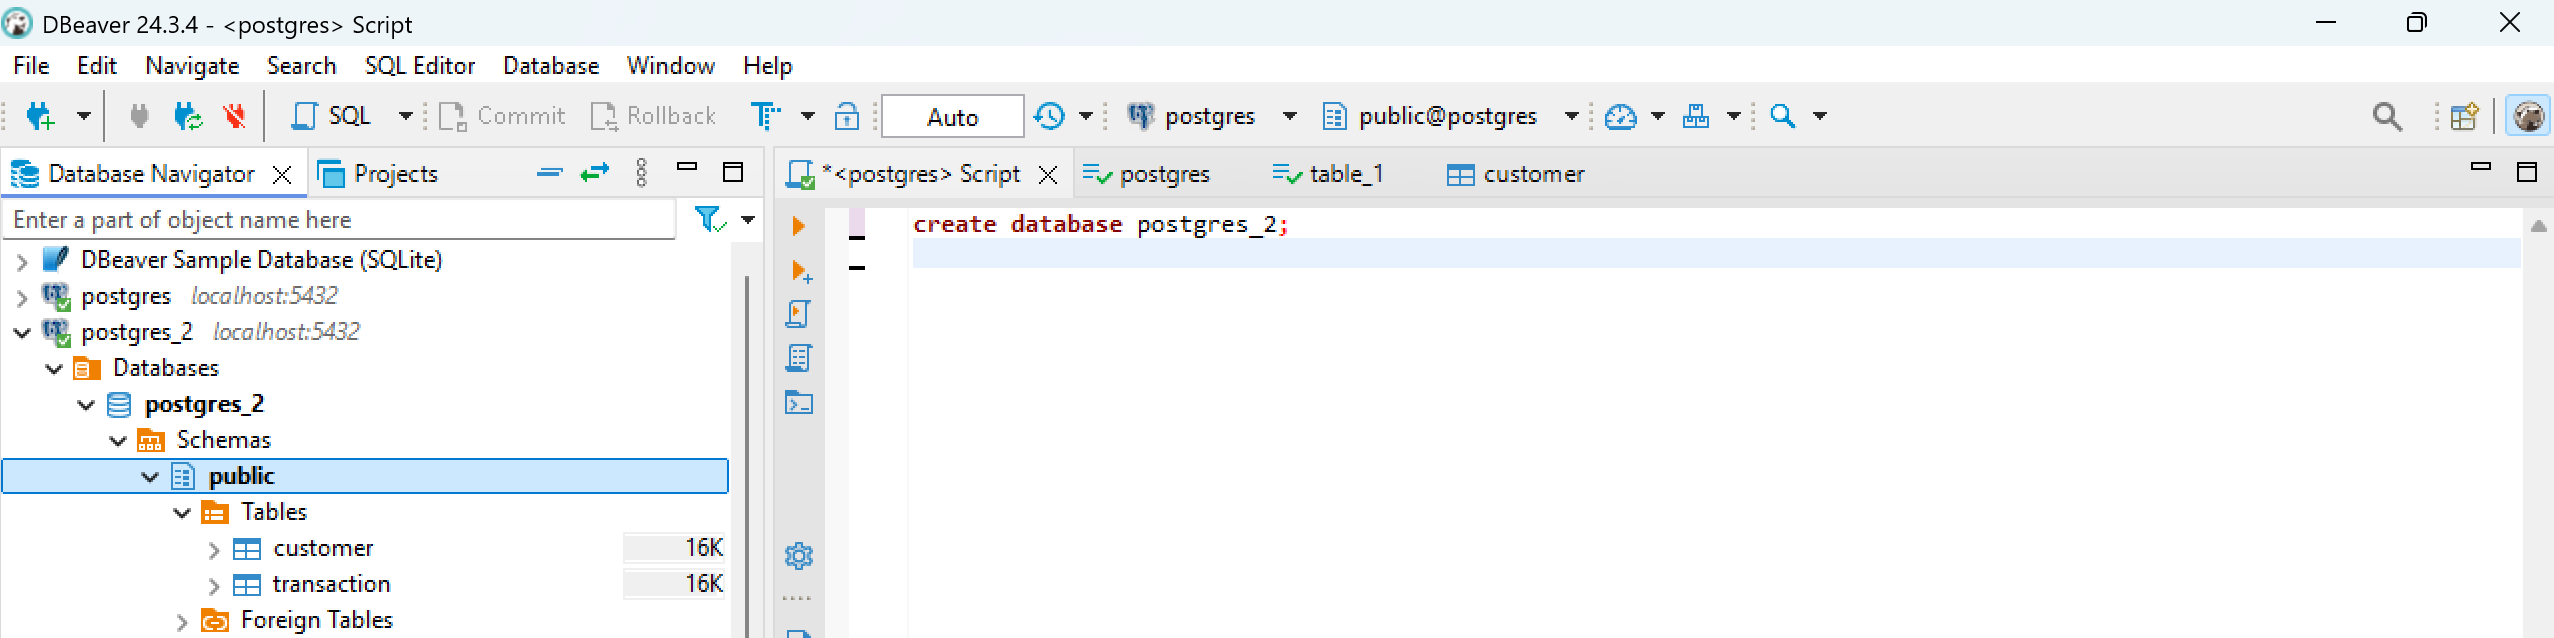

In [95]:
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}')

In [96]:
customer.columns = customer.columns.str.lower()

In [97]:
# customer.to_sql('customer', con=engine, if_exists='append', index=False)
existing_customers = pd.read_sql("SELECT customer_id FROM customer", con=engine)
customer = customer[~customer["customer_id"].isin(existing_customers["customer_id"])]
customer.to_sql('customer', con=engine, if_exists='append', index=False)

780

In [98]:
# transaction.to_sql('transaction', con=engine, if_exists='append', index=False)
existing_transactions = pd.read_sql("SELECT transaction_id FROM transaction", con=engine)
transaction = transaction[~transaction["transaction_id"].isin(existing_transactions["transaction_id"])]
transaction.to_sql('transaction', con=engine, if_exists='append', index=False)

445

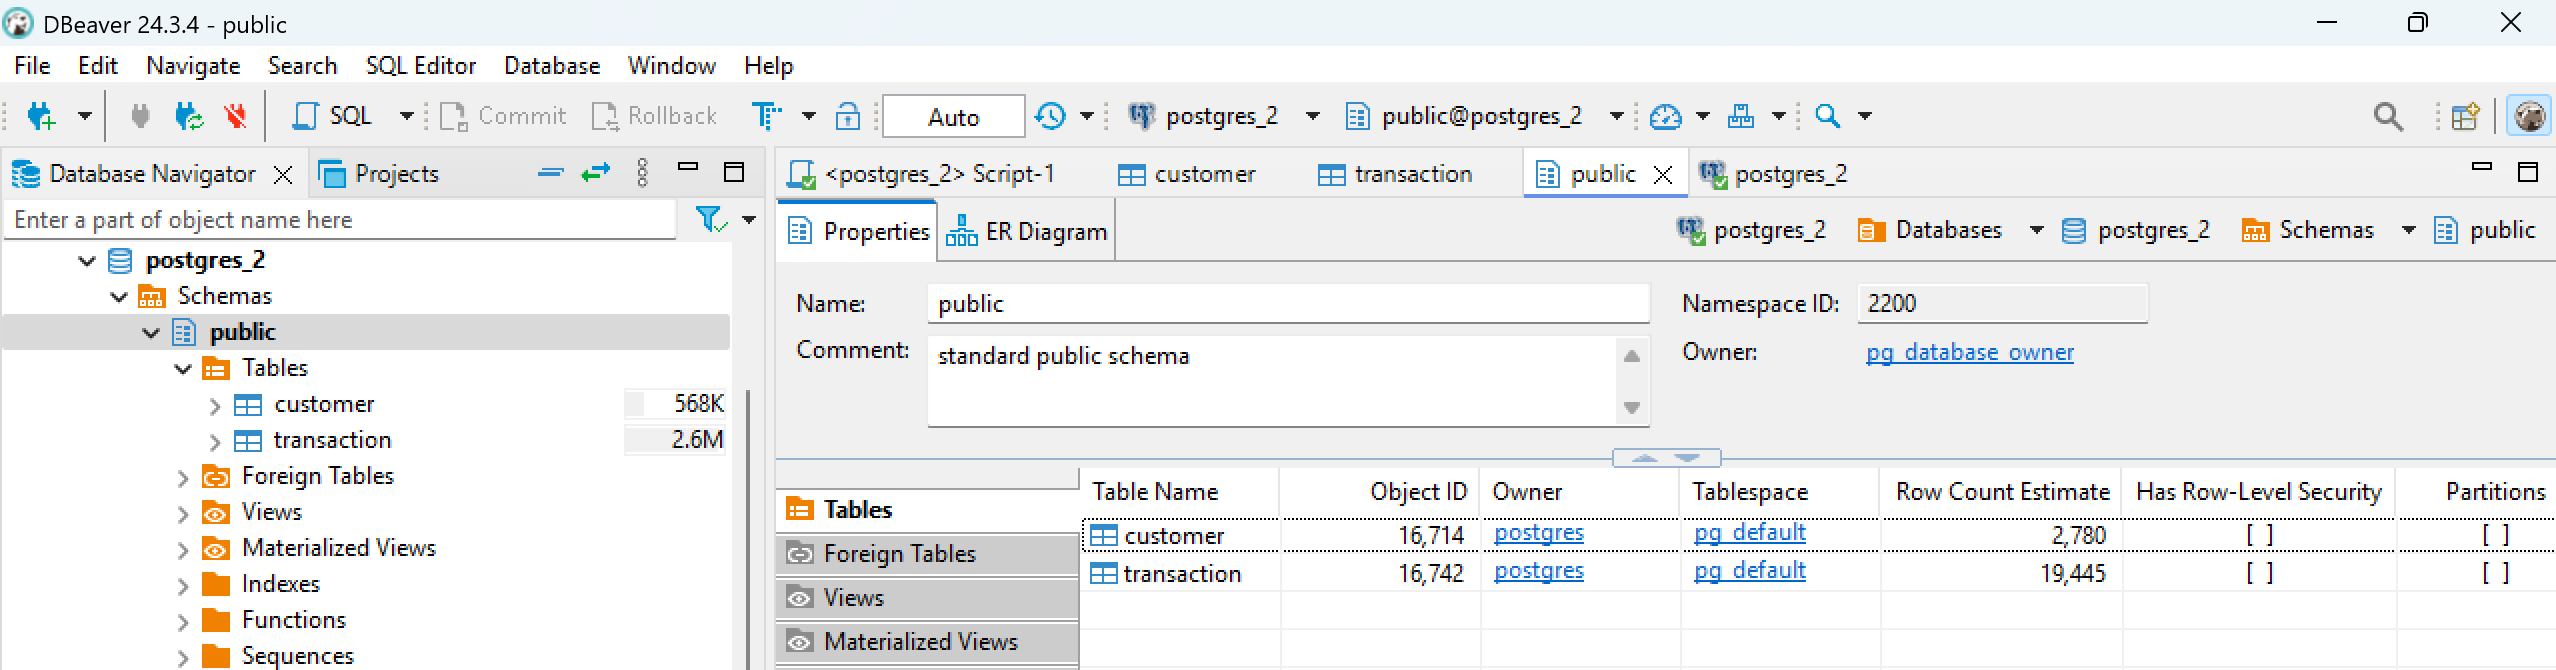

(1 балл) Вывести все уникальные бренды, у которых стандартная стоимость выше 1500 долларов.

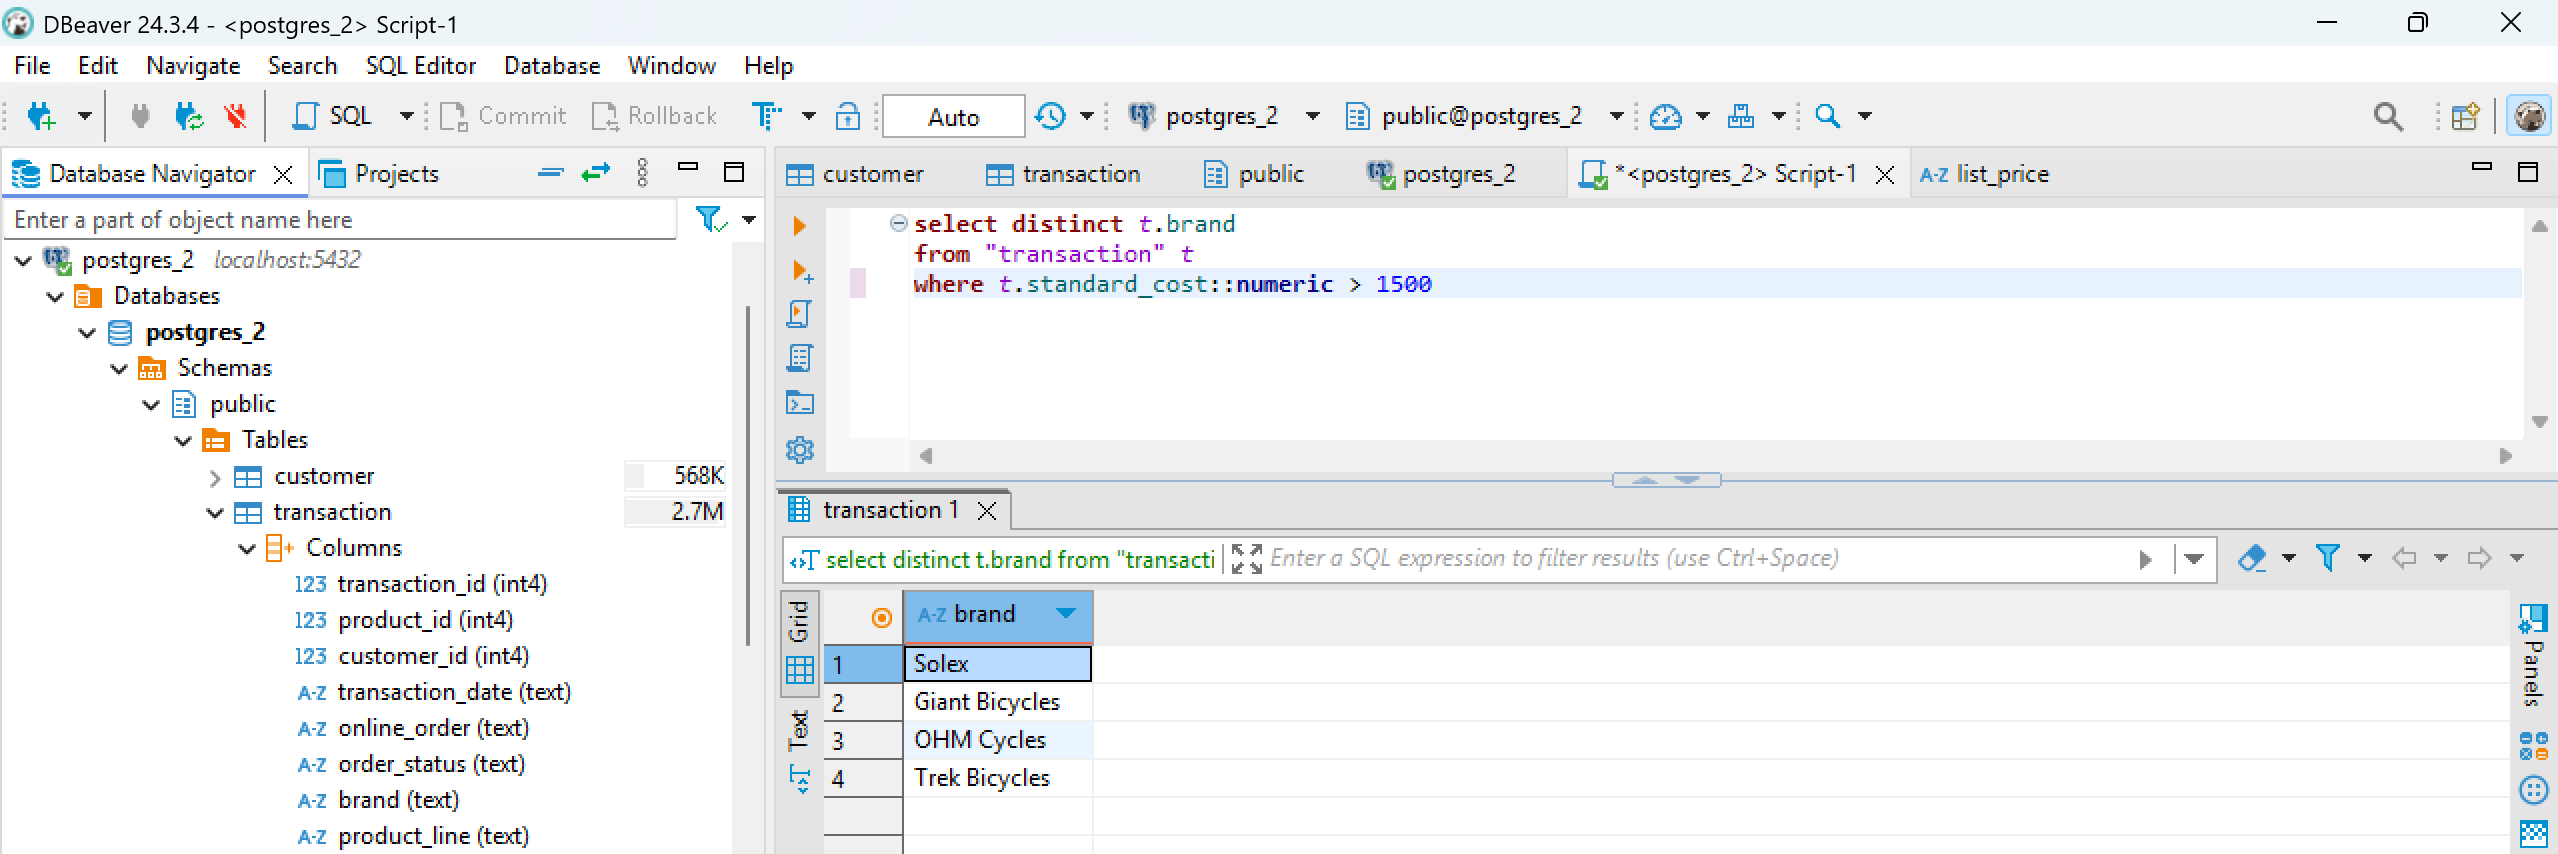

(1 балл) Вывести все подтвержденные транзакции за период '2017-04-01' по '2017-04-09' включительно.

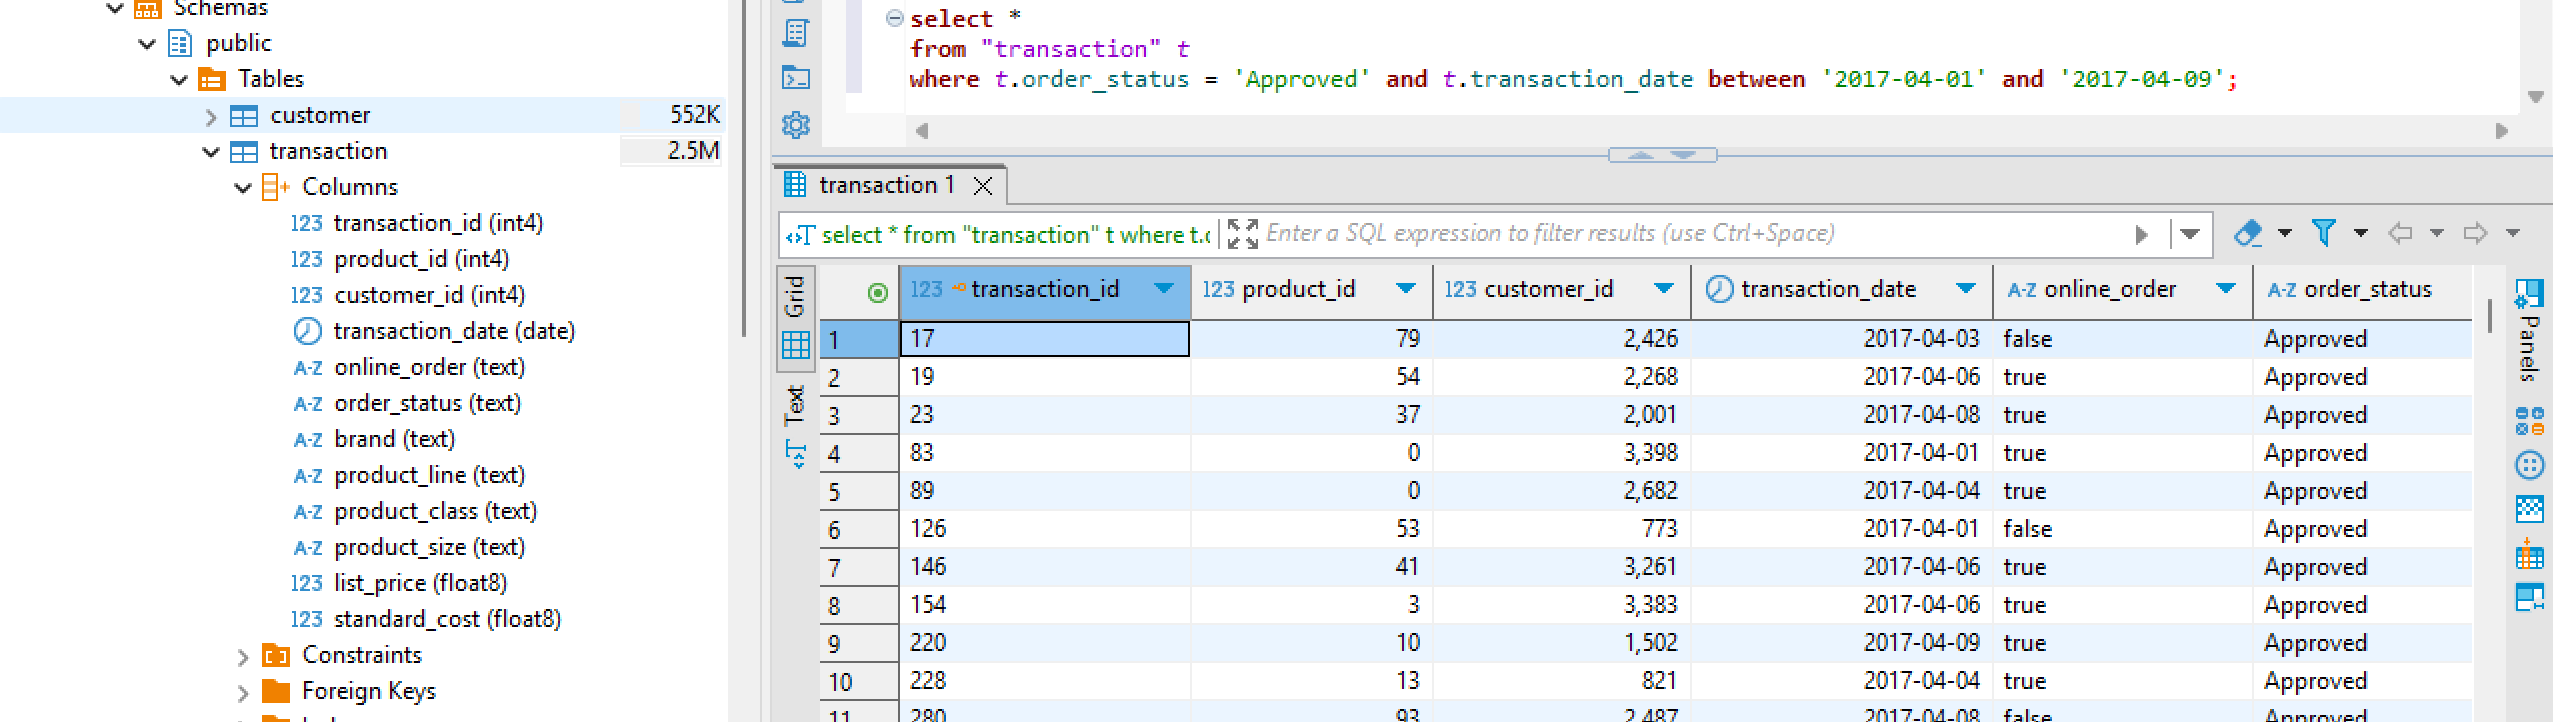

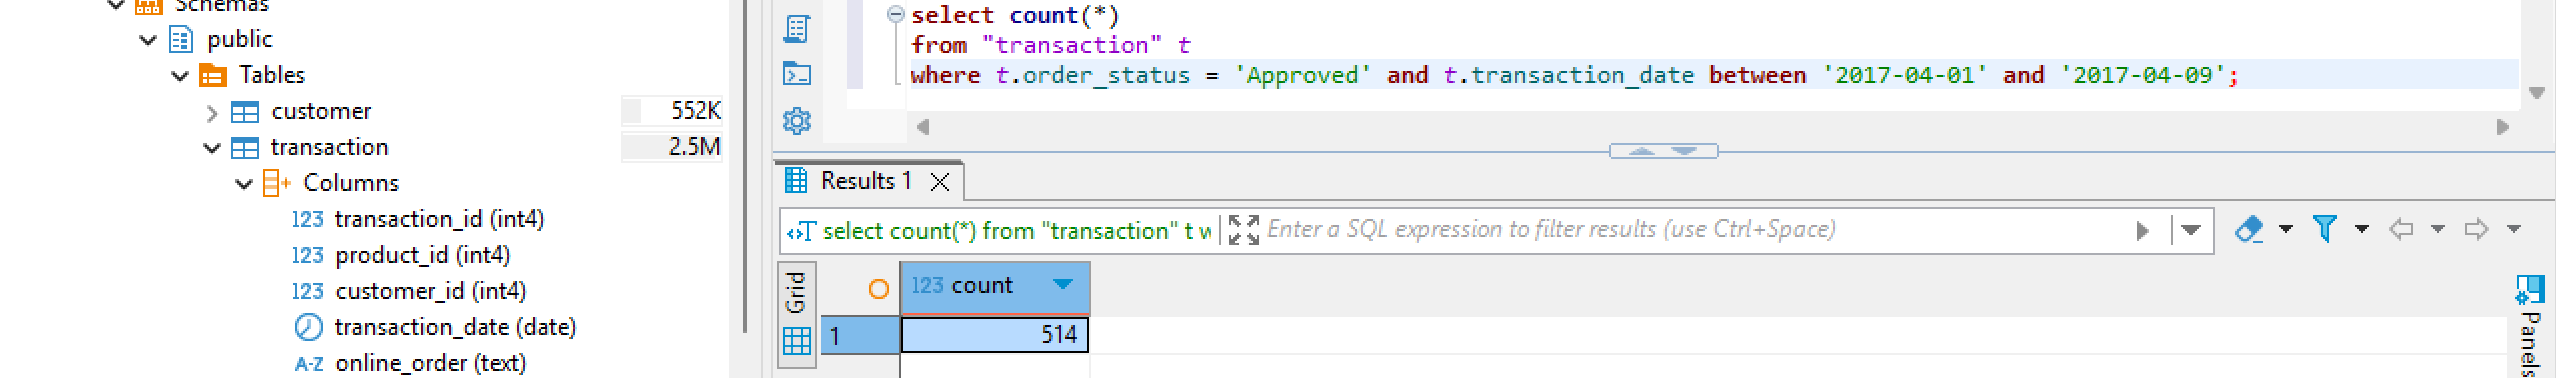

(1 балл) Вывести все профессии у клиентов из сферы IT или Financial Services, которые начинаются с фразы 'Senior'.

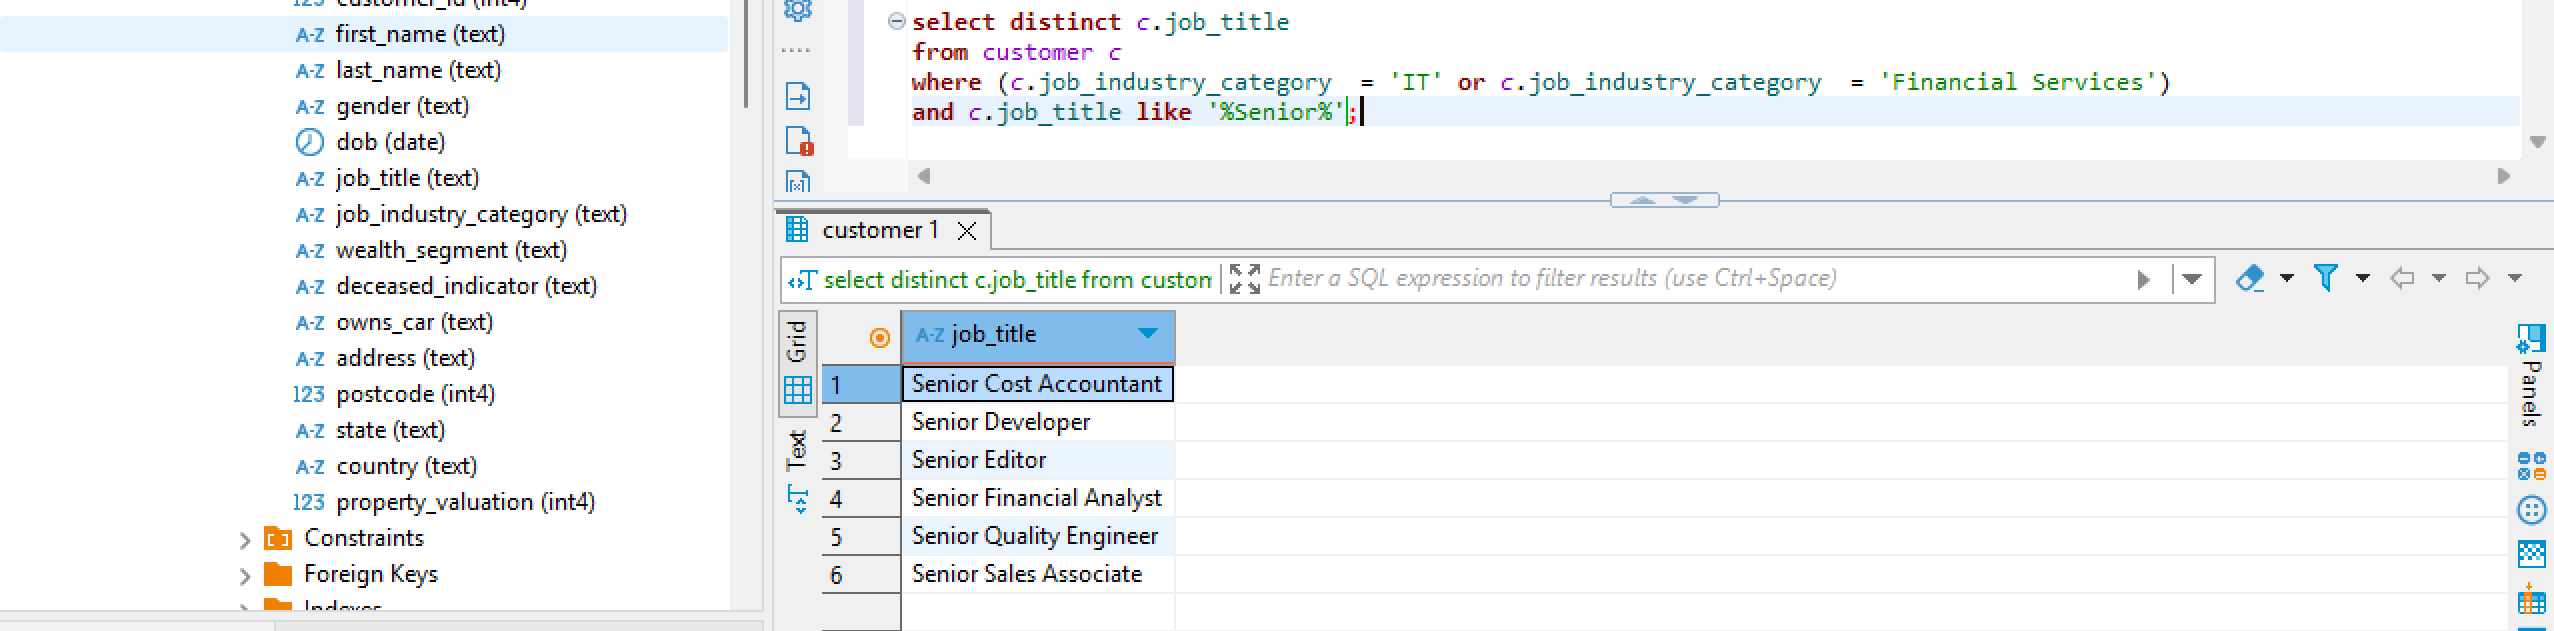

(1 балл) Вывести все бренды, которые закупают клиенты, работающие в сфере Financial Services

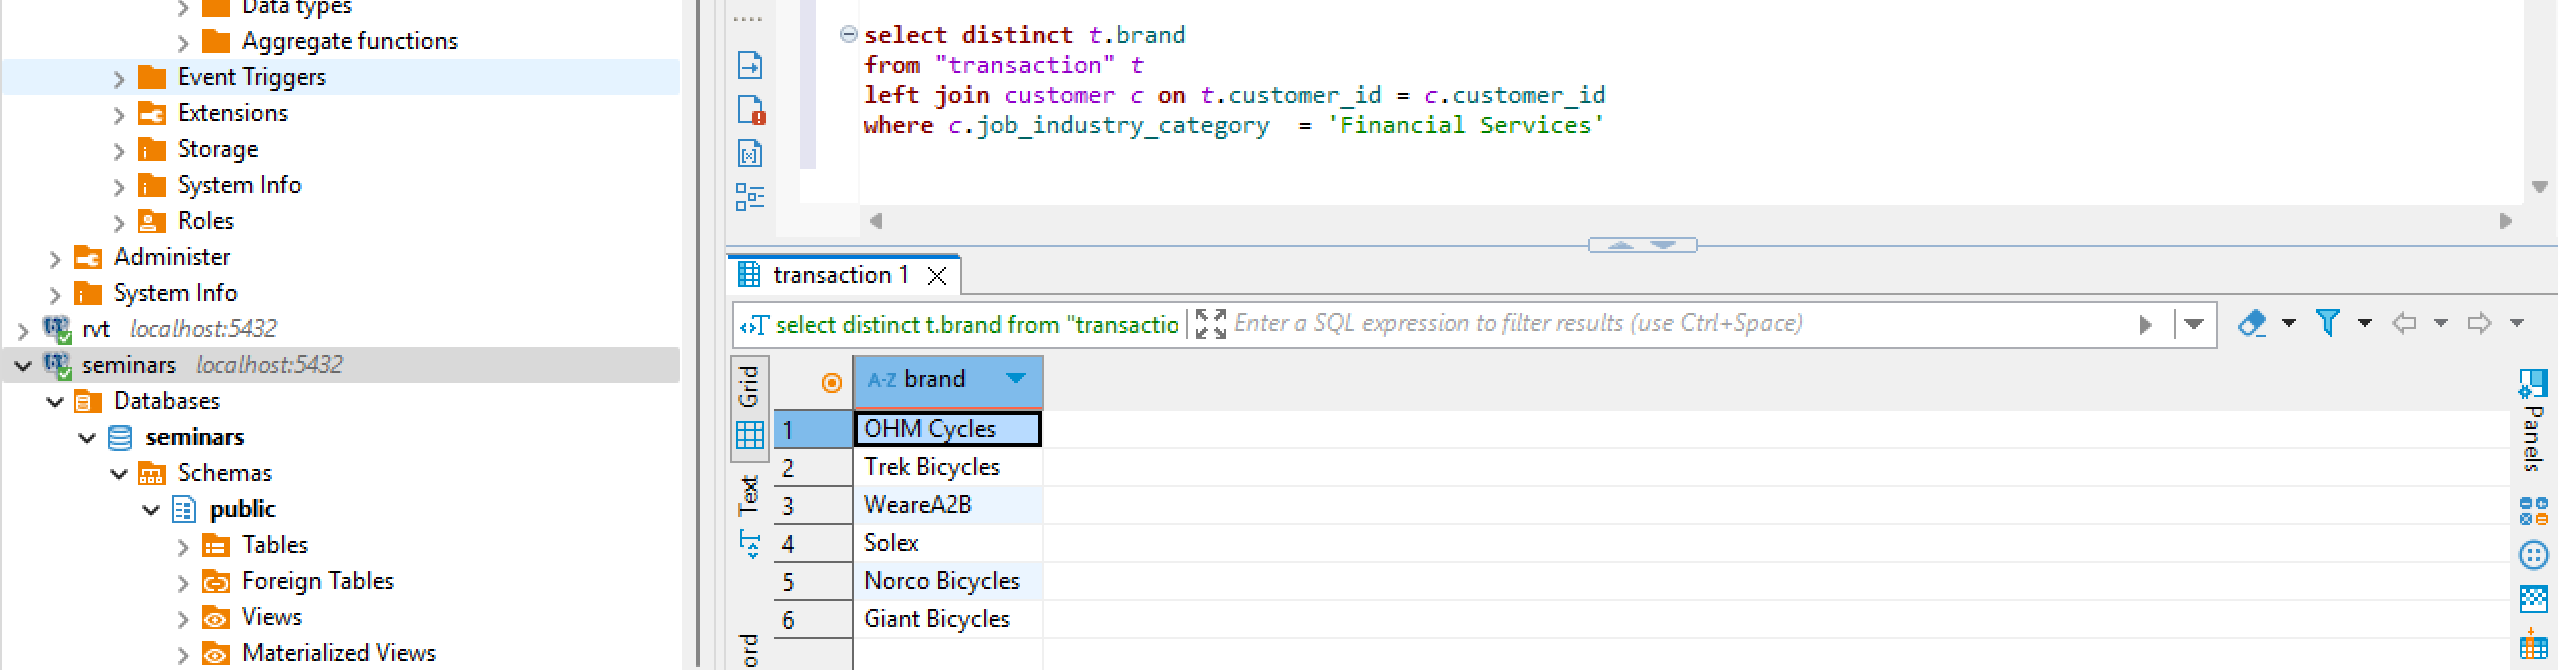

(1 балл) Вывести 10 клиентов, которые оформили онлайн-заказ продукции из брендов 'Giant Bicycles', 'Norco Bicycles', 'Trek Bicycles'.

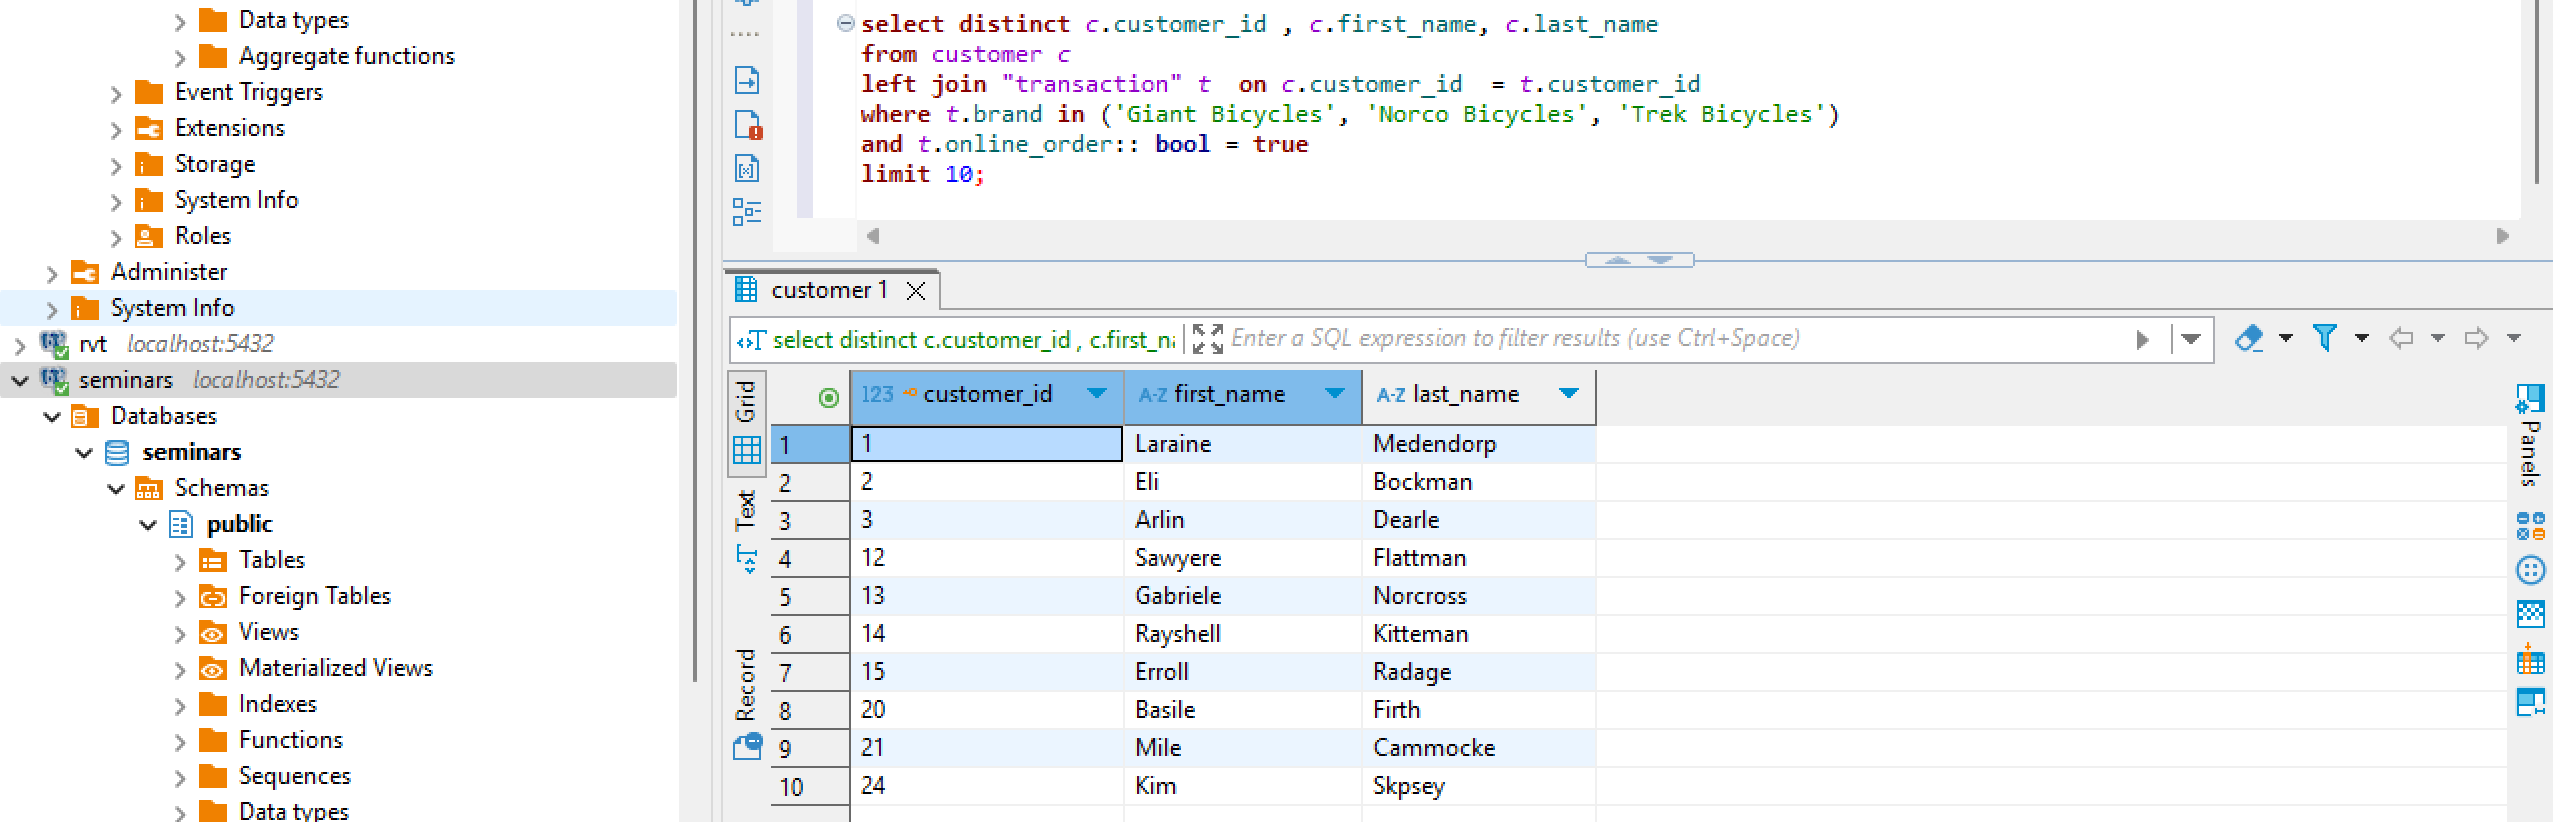

(1 балл) Вывести всех клиентов, у которых нет транзакций.

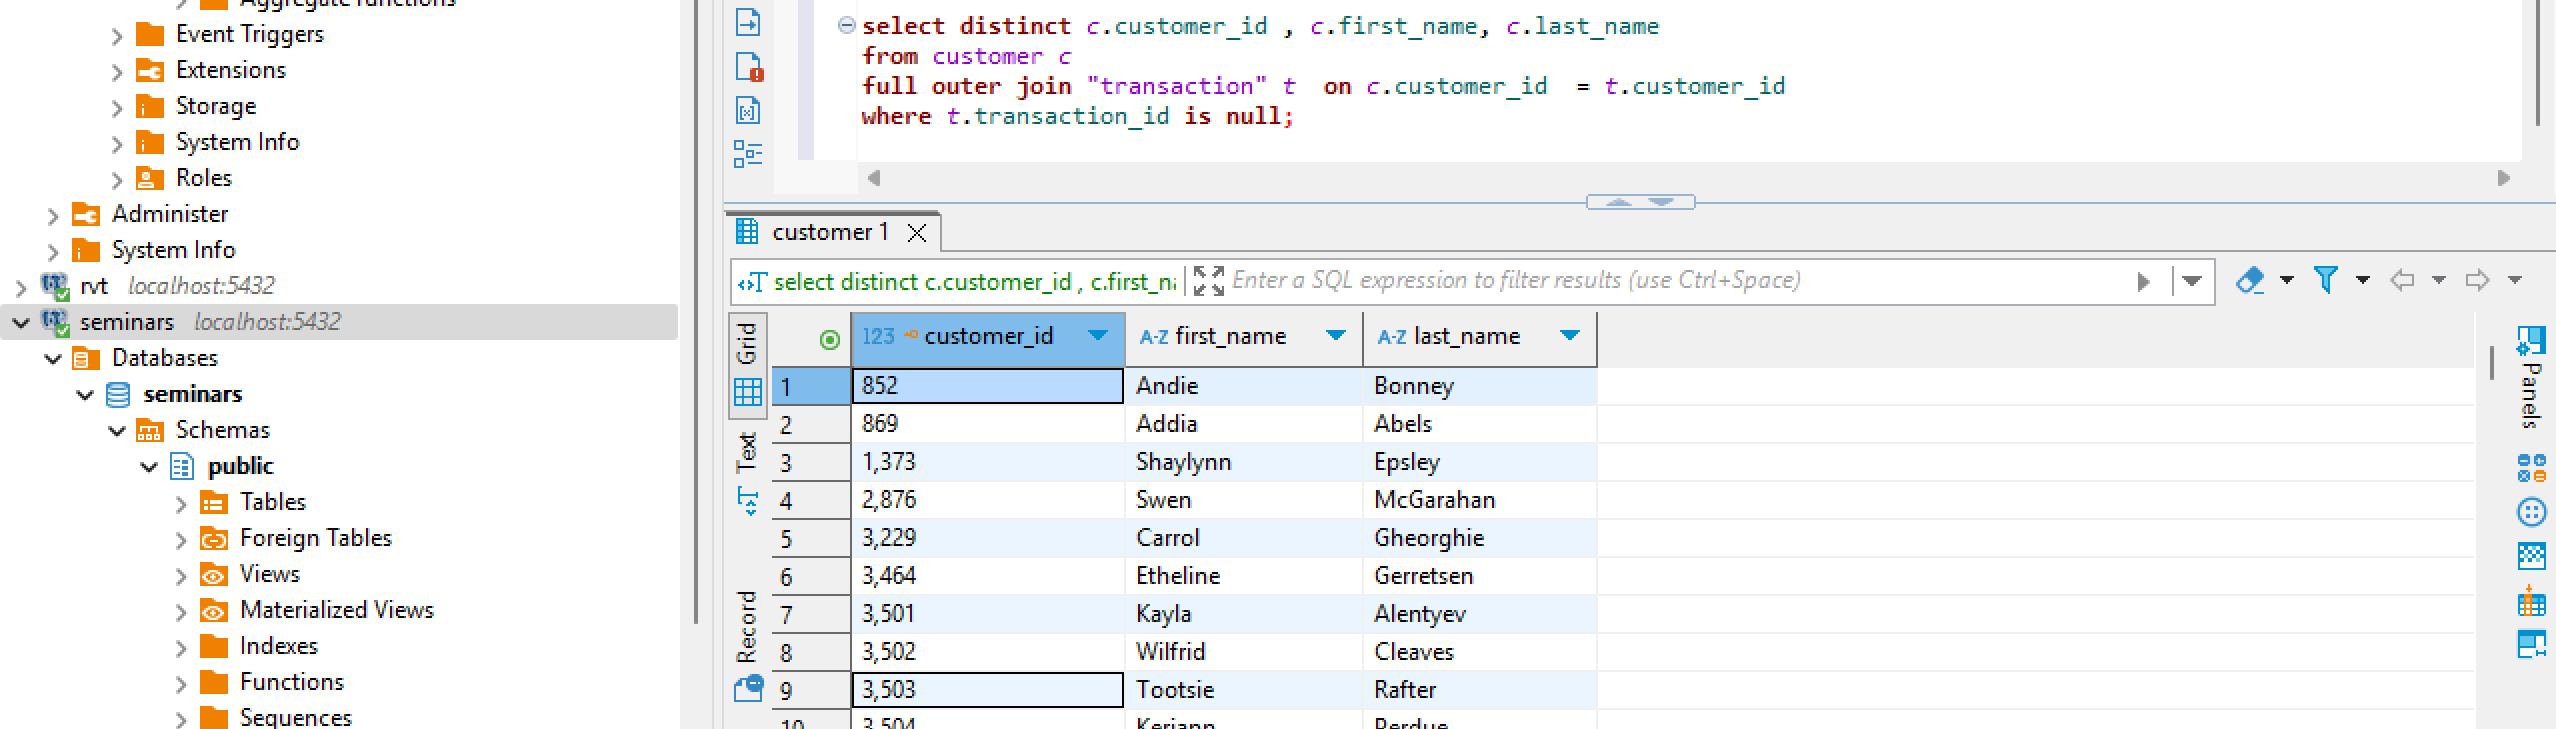

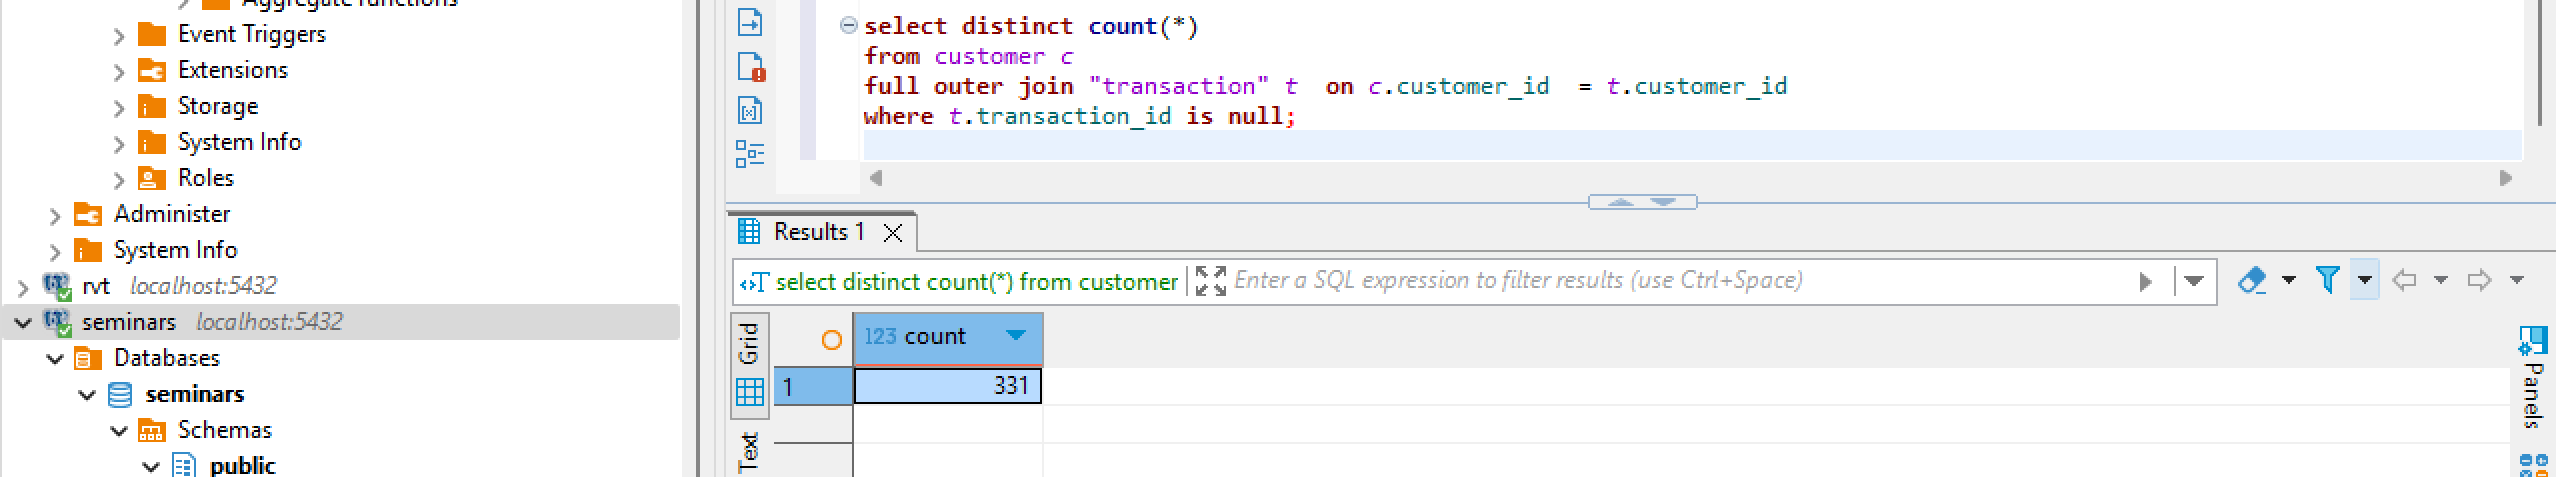

(2 балла) Вывести всех клиентов из IT, у которых транзакции с максимальной стандартной стоимостью.

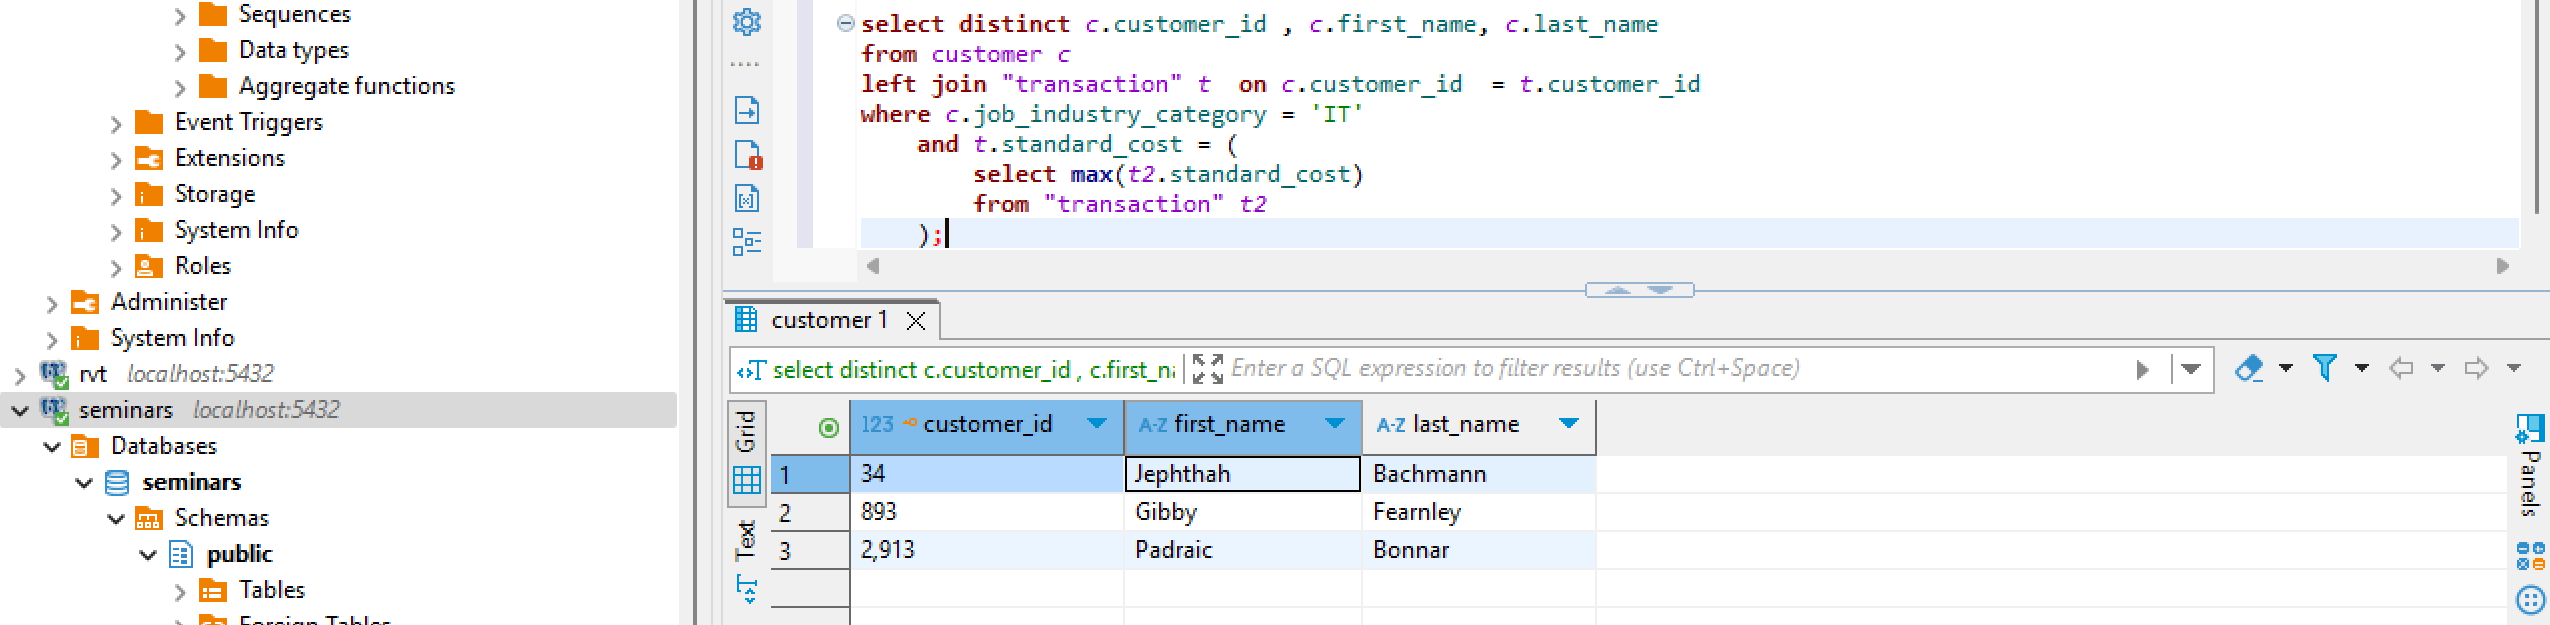

(2 балла) Вывести всех клиентов из сферы IT и Health, у которых есть подтвержденные транзакции за период '2017-07-07' по '2017-07-17'.

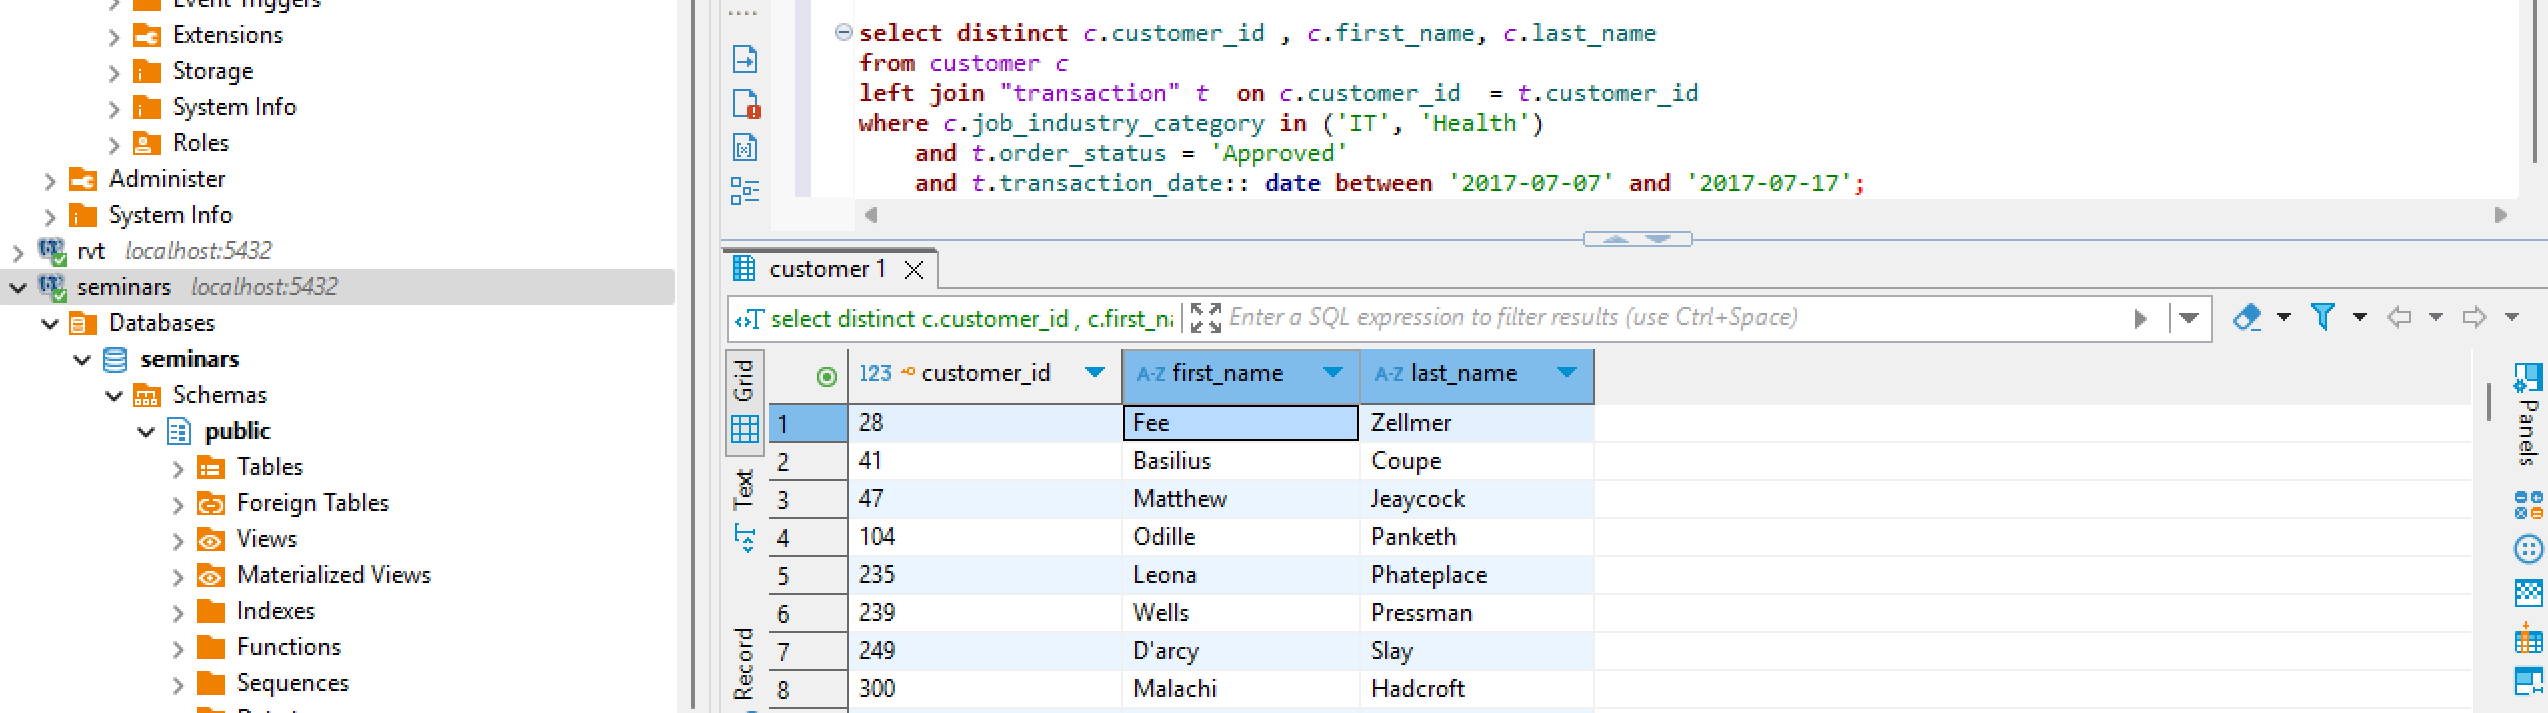

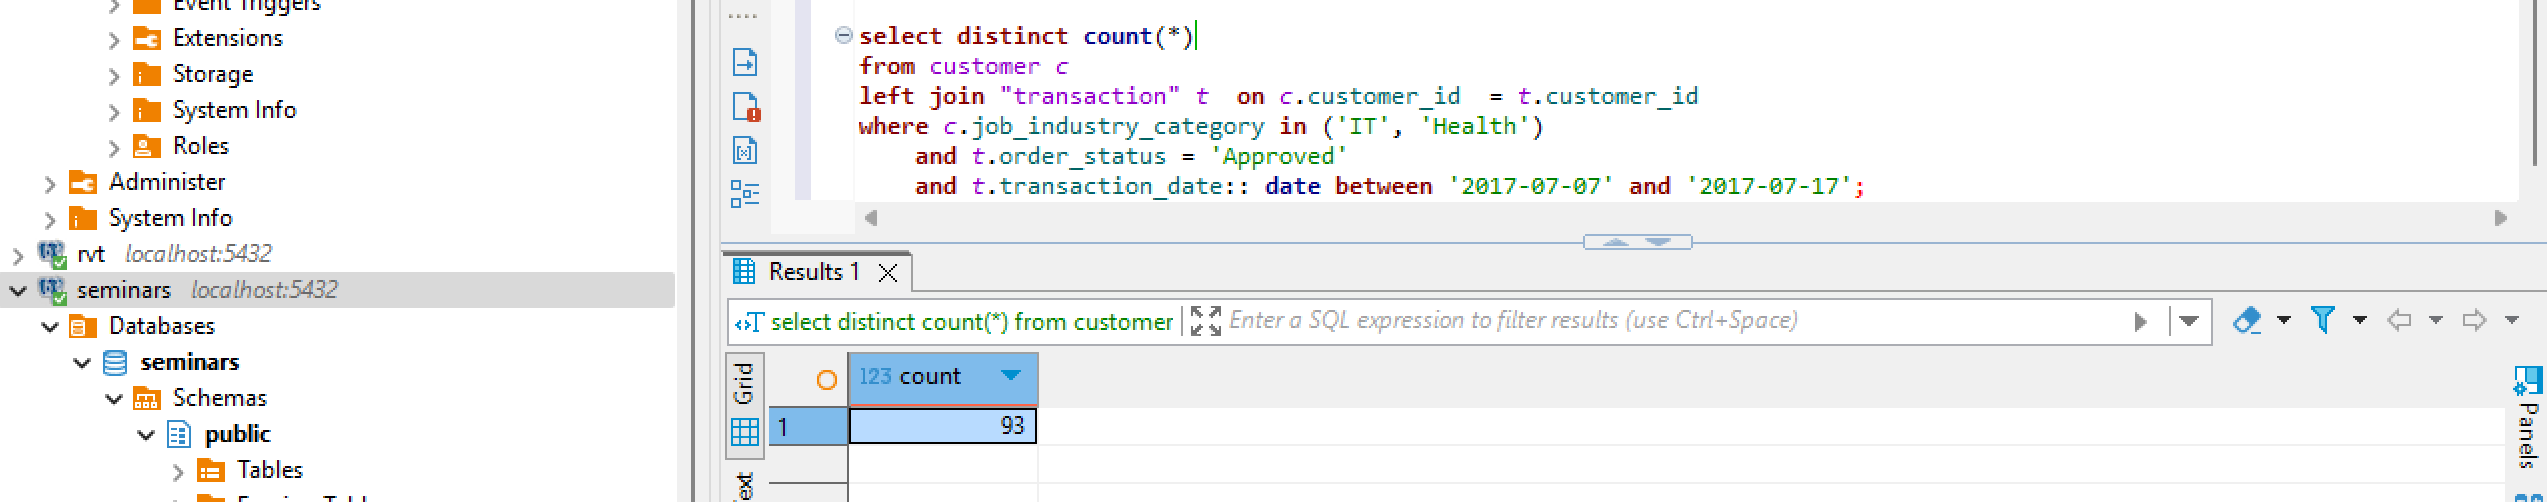

```
select distinct t.brand 
from "transaction" t
where t.standard_cost::numeric > 1500

select count(*)
from "transaction" t 
where t.order_status = 'Approved' and t.transaction_date between '2017-04-01' and '2017-04-09';

select distinct c.job_title
from customer c 
where (c.job_industry_category  = 'IT' or c.job_industry_category  = 'Financial Services') 
and c.job_title like '%Senior%';

select distinct t.brand
from "transaction" t
left join customer c on t.customer_id = c.customer_id 
where c.job_industry_category  = 'Financial Services'

select distinct c.customer_id , c.first_name, c.last_name 
from customer c 
left join "transaction" t  on c.customer_id  = t.customer_id 
where t.brand in ('Giant Bicycles', 'Norco Bicycles', 'Trek Bicycles')
and t.online_order:: bool = true
limit 10;

select distinct c.customer_id , c.first_name, c.last_name 
from customer c 
full outer join "transaction" t  on c.customer_id  = t.customer_id 
where t.transaction_id is null;

select distinct count(*) 
from customer c 
full outer join "transaction" t  on c.customer_id  = t.customer_id 
where t.transaction_id is null;

select distinct c.customer_id , c.first_name, c.last_name 
from customer c 
left join "transaction" t  on c.customer_id  = t.customer_id 
where c.job_industry_category = 'IT'
	and t.standard_cost = (
		select max(t2.standard_cost)
		from "transaction" t2
	);

select distinct c.customer_id , c.first_name, c.last_name 
from customer c 
left join "transaction" t  on c.customer_id  = t.customer_id 
where c.job_industry_category in ('IT', 'Health')
	and t.order_status = 'Approved'
	and t.transaction_date:: date between '2017-07-07' and '2017-07-17';

select distinct count(*) 
from customer c 
left join "transaction" t  on c.customer_id  = t.customer_id 
where c.job_industry_category in ('IT', 'Health')
	and t.order_status = 'Approved'
	and t.transaction_date:: date between '2017-07-07' and '2017-07-17';
```